In [1]:
#import analysis
import sys
sys.path.insert(0,'./scripts/')

import test_features
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import subplots,scatter
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.externals import joblib
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
import scipy.stats as stats
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.model_selection import cross_val_score
#from yellowbrick.features import RFECV
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import xgboost

C:\Users\Richard\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [7]:
#import analysis
import sys
sys.path.insert(0,'./scripts/')

import test_features
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots,scatter
import seaborn as sns
from sklearn.externals import joblib
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.model_selection import cross_val_score
import os

def read_data(file_dir,DB_file_dir):
    
    data = []
    label = []
    
    for i in range(len(file_dir)):
        print('loading..{}'.format(file_dir[i]))
        df=pd.read_pickle(file_dir[i])
        psm_ID=list(pd.read_csv(DB_file_dir[i])['Scan'])
        y=np.zeros(df.shape[0])

        for i in range(0,df.shape[0]):
            if df.index[i] in psm_ID:
                y[i]=1

        X = df.drop('RT',axis=1).fillna(0).values
        y =y.astype(int)[X.sum(axis=1)!=0]
        X = X[X.sum(axis=1)!=0]
        X = X/X.max(axis=1).reshape(X.shape[0],1) #normalization
        data.append(X)
        label.append(y)
        del X

    data = np.concatenate((data))
    label = np.concatenate((label))
    return data,label

file_dir = ['Orbitrap_aplysia/abd.pkl','Orbitrap_aplysia/buc.pkl']
DB_file_dir = ['Aplysia_ganglia/Abdominal/DB search psm.csv','Aplysia_ganglia/Buccal/DB search psm.csv']

data,label = read_data(file_dir,DB_file_dir)

loading..Orbitrap_aplysia/abd.pkl
loading..Orbitrap_aplysia/buc.pkl


In [8]:
data = data.reshape((data.shape[0],data.shape[1]))
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.3, random_state=1)
del data

In [5]:
# Cs=[0.1]
# gammas = [0.1]
# param_grid = {'C': Cs, 'gamma': gammas}

# rbf_svm = test_features.SVM_classi(X_train, y_train, 'rbf', param_grid, True, 1)

In [6]:
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))


In [ ]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0,0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 7,10],
        'learning_rate':[0.1,0.05,0.01,0.005],
        'reg_alpha':[0,1e-5, 1e-2, 0.1, 1]
        }

xgb = xgboost.XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=5,scale_pos_weight=scale_weight)
folds = 3
param_comb = 7

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 19)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc',
                                   n_jobs=2, cv=skf.split(X_train,y_train), verbose=3, random_state=19 )

start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


In [9]:
scale_weight = y_train[y_train==0].shape[0]/y_train[y_train==1].shape[0]

xgb_best = xgboost.XGBClassifier(learning_rate=0.1, n_estimators=600, objective='binary:logistic',scale_pos_weight=scale_weight,
                    subsample=1,reg_alpha=0,min_child_weight=5,max_depth=4,gamma=0,colsample_bytree=1,nthread = 8)

In [10]:
#training GBT
xgb_best.fit(x_train,y_train)

y_pred_xgb_best = xgb_best.predict(x_test)
y_pred_xgb_prob_best = xgb_best.predict_proba(x_test)
report_dict_xgb_best = classification_report(y_test, y_pred_xgb_best, output_dict=True)

In [49]:
#Loading trained DL model

import os
cuda_path = 'C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v10.0\\bin'
cudnn_path = 'D:\\Work\\software\\cuda\\bin'
os.environ["PATH"] += os.pathsep + cuda_path
os.environ["PATH"] += os.pathsep + cudnn_path
import keras
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
sess = tf.Session(config=config)
set_session(sess)
import keras
from keras.layers import Dense, Conv1D, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling1D, AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

INTERESTING_CLASS_ID =  1 # Choose the class of interest

def single_class_accuracy(y_true, y_pred):
    class_id_true = K.argmax(y_true, axis=-1)
    class_id_preds = K.argmax(y_pred, axis=-1)
    accuracy_mask = K.cast(K.equal(class_id_preds, INTERESTING_CLASS_ID), 'int32')
    #recall_mask = K.cast(K.equal(class_id_true, INTERESTING_CLASS_ID), 'int32')

    class_acc_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * accuracy_mask
    #class_recall_tensor = K.cast(K.equal(class_id_true, class_id_true), 'int32') * recall_mask
    class_acc = K.sum(class_acc_tensor) / K.maximum(K.sum(accuracy_mask), 1)
    #class_recall = K.sum(class_recall_tensor) / K.maximum(K.sum(recall_mask), 1)
    return class_acc

def single_class_recall(y_true, y_pred):
    class_id_true = K.argmax(y_true, axis=-1)
    class_id_preds = K.argmax(y_pred, axis=-1)
    #accuracy_mask = K.cast(K.equal(class_id_preds, INTERESTING_CLASS_ID), 'int32')
    recall_mask = K.cast(K.equal(class_id_true, INTERESTING_CLASS_ID), 'int32')

    #class_acc_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * accuracy_mask
    class_recall_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * recall_mask
    #class_acc = K.sum(class_acc_tensor) / K.maximum(K.sum(accuracy_mask), 1)
    class_recall = K.sum(class_recall_tensor) / K.maximum(K.sum(recall_mask), 1)
    return class_recall

dependencies = {
    'recall_m': recall_m,'precision_m':precision_m,'f1_m':f1_m,'single_class_accuracy':single_class_accuracy,
    'single_class_recall':single_class_recall
}

model = keras.models.load_model('models/Abd_Buc_ResNet11v2_model.074.h5',custom_objects=dependencies)

In [55]:
x_test_ = x_test.reshape((x_test.shape[0],x_test.shape[1],1))
y_pred = model.predict(x_test_)

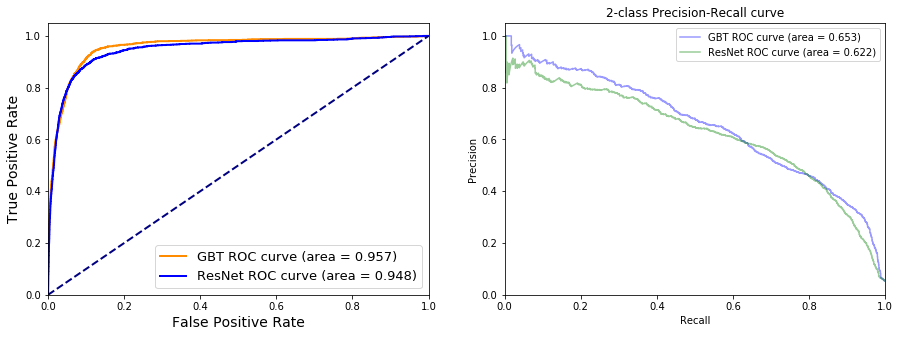

In [71]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
precision, recall, threshold_pr = precision_recall_curve(y_test, y_pred_xgb_prob_best[:,1])

ftp,tpr,threshold_roc = roc_curve(y_test,y_pred_xgb_prob_best[:,1])

precision2, recall2, threshold_pr2 = precision_recall_curve(y_test, y_pred[:,1])

ftp2,tpr2,threshold_roc2 = roc_curve(y_test,y_pred[:,1])

fig,axes = subplots(1,2,figsize=(15,5))
ax = axes.ravel()
ax[0].plot(ftp, tpr, color='darkorange',
         lw=2, label='GBT ROC curve (area = %0.3f)' % auc(ftp,tpr))
ax[0].plot(ftp2, tpr2, color='blue',
         lw=2, label='ResNet ROC curve (area = %0.3f)' % auc(ftp2,tpr2))

ax[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].set_xlabel('False Positive Rate',fontsize=14)
ax[0].set_ylabel('True Positive Rate',fontsize=14)
ax[0].legend(loc="lower right",fontsize=13)

thresholds = np.append(threshold_pr, 1)
f1_scores = 2*(precision*recall)/(precision+recall)

ax[1].plot(recall, precision, color='b', alpha=0.4,label='GBT ROC curve (area = %0.3f)' % auc(recall,precision))
ax[1].plot(recall2, precision2, color='g', alpha=0.4,label='ResNet ROC curve (area = %0.3f)' % auc(recall2,precision2))

ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlim([0.0, 1.0])
ax[1].set_title('2-class Precision-Recall curve')
ax[1].legend()

Threshold cutoff:  0.69092226
Max F1-score at cut-off :  0.6207105982386881


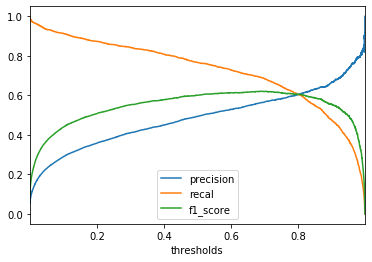

In [57]:
scrs = pd.DataFrame({'precision' : precision[1:], 'recal' : recall[1:], 'thresholds' : threshold_pr, 'f1_score':f1_scores[1:]})
print("Threshold cutoff: ",scrs.loc[scrs['f1_score'] == scrs.f1_score.max(),'thresholds'].iloc[0])
print("Max F1-score at cut-off : ",scrs.f1_score.max())

ax = scrs.plot(x='thresholds')

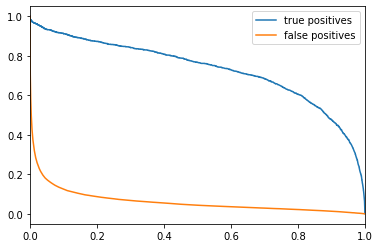

In [58]:
plt.plot(threshold_roc,tpr)
plt.plot(threshold_roc,ftp)
plt.xlim([0,1])
plt.legend(['true positives','false positives'])

In [100]:
negative_index = np.where(y_train==0)[0]
positive_index = np.where(y_train==1)[0]

C:\Users\Richard\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


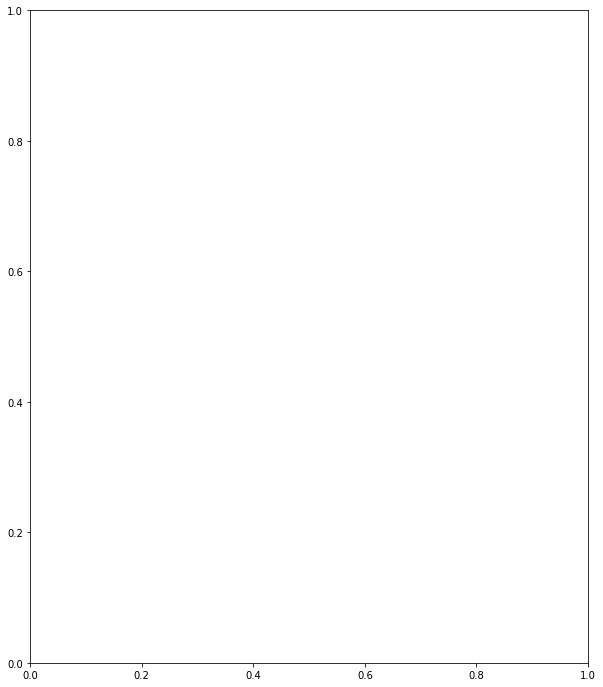

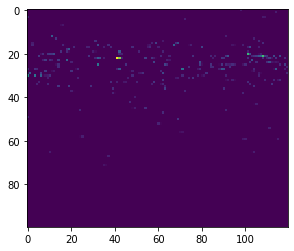

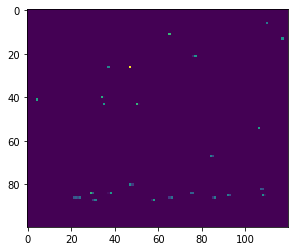

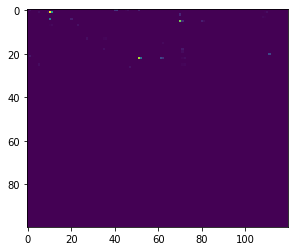

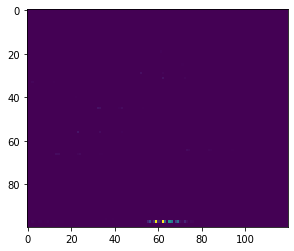

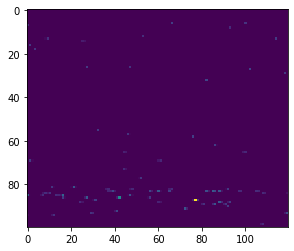

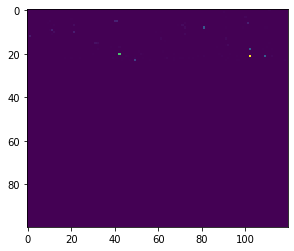

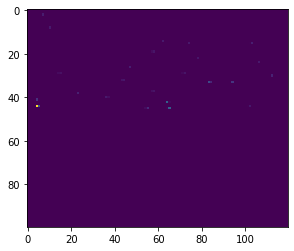

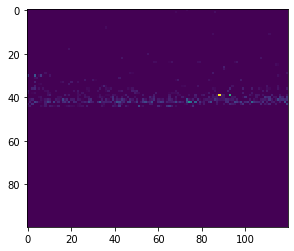

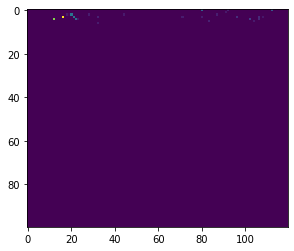

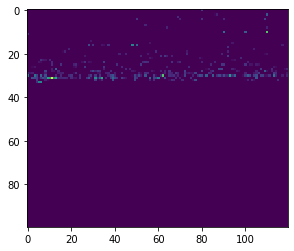

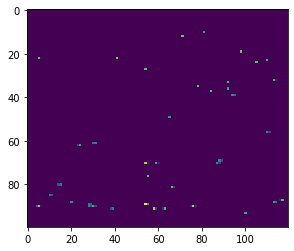

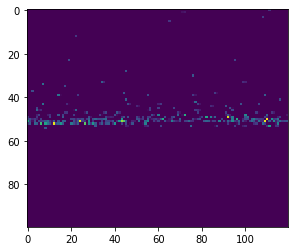

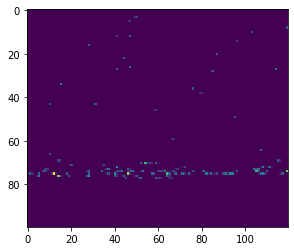

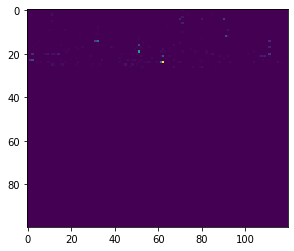

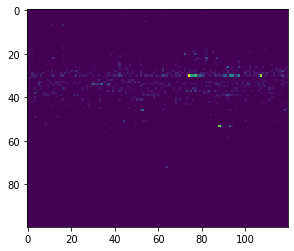

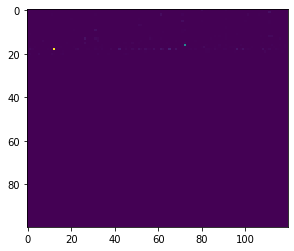

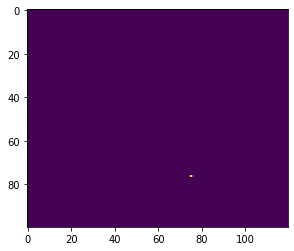

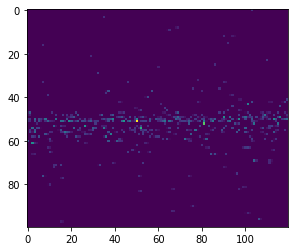

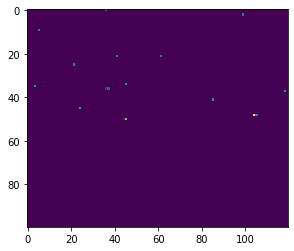

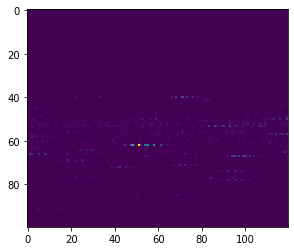

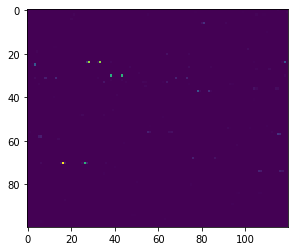

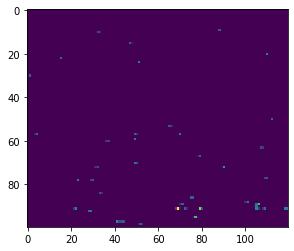

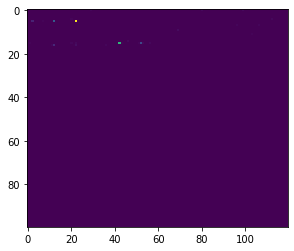

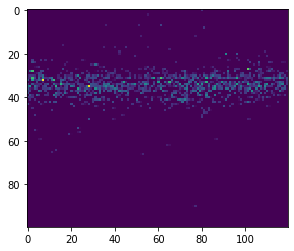

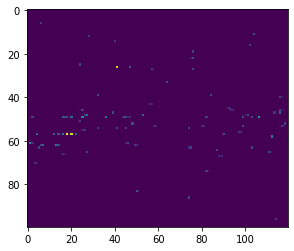

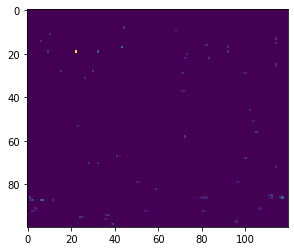

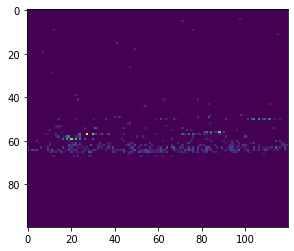

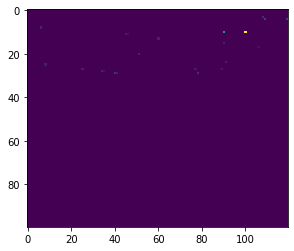

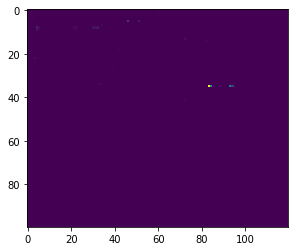

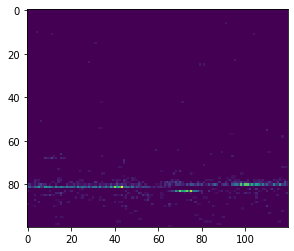

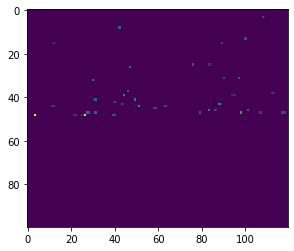

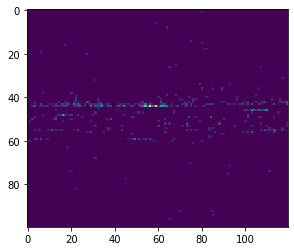

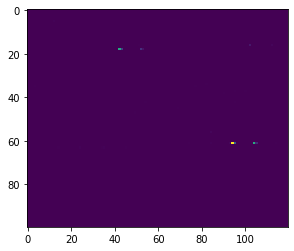

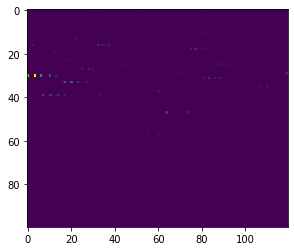

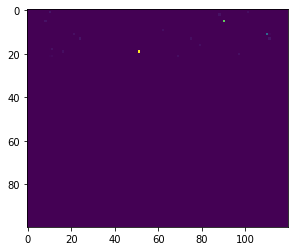

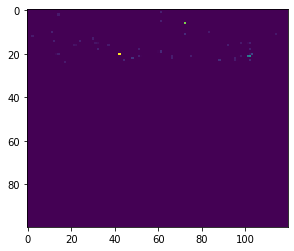

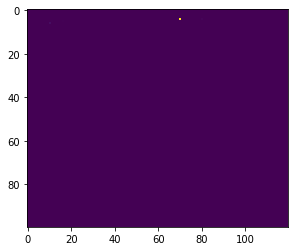

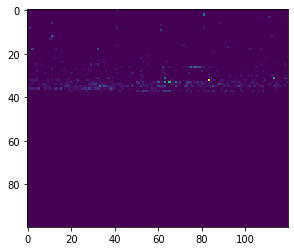

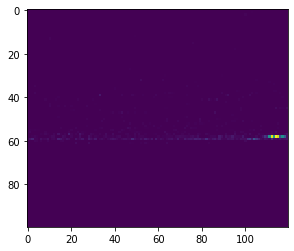

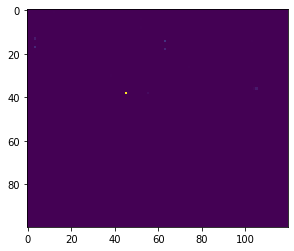

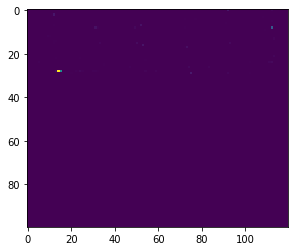

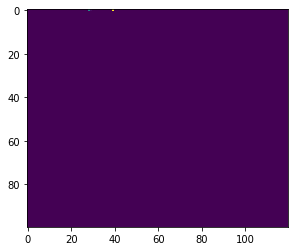

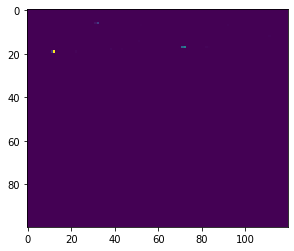

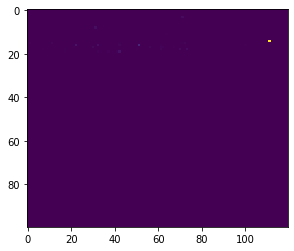

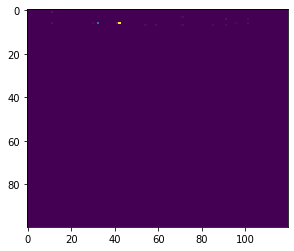

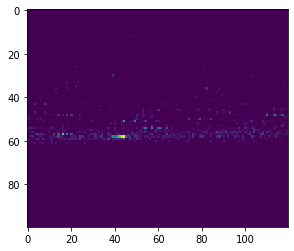

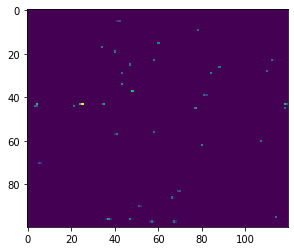

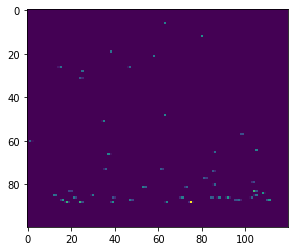

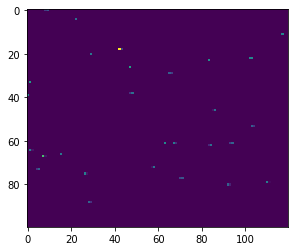

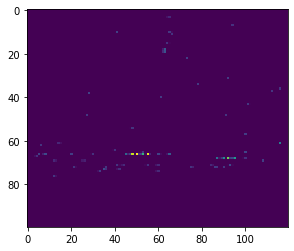

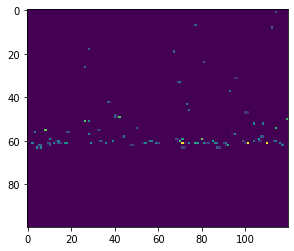

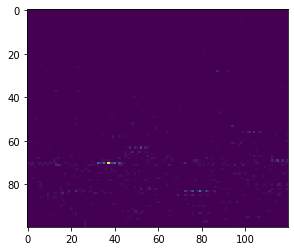

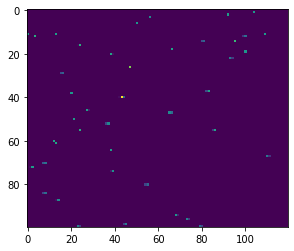

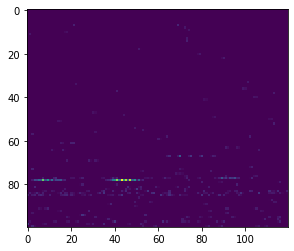

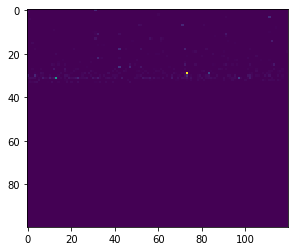

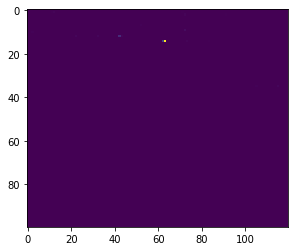

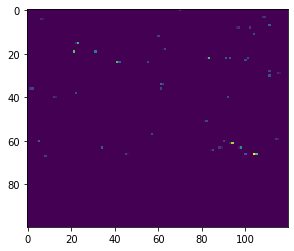

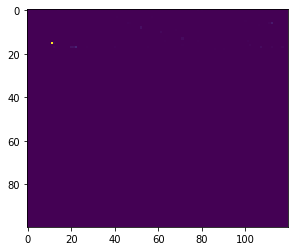

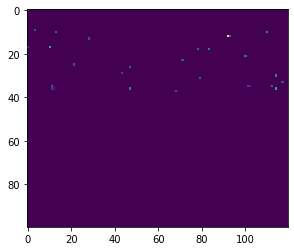

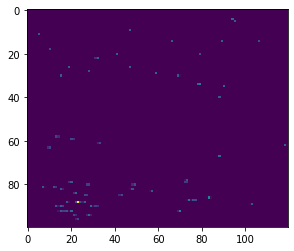

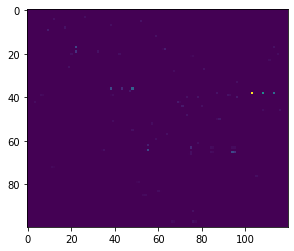

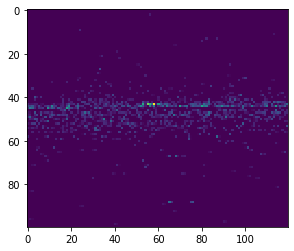

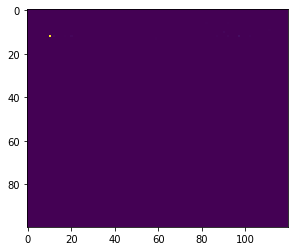

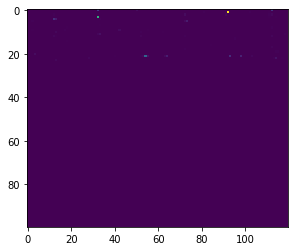

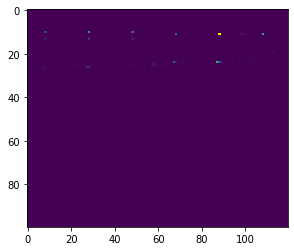

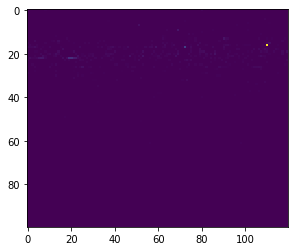

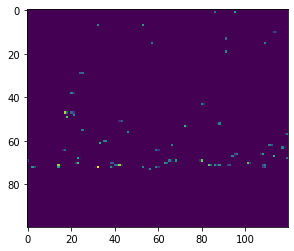

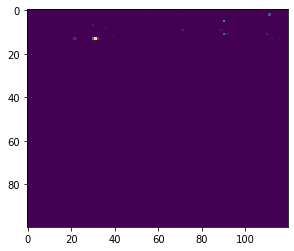

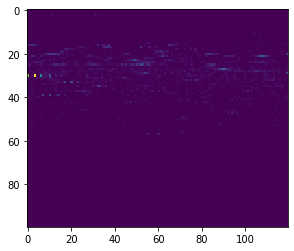

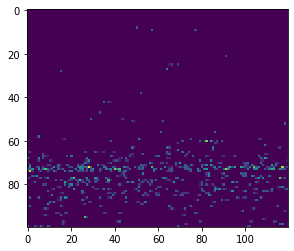

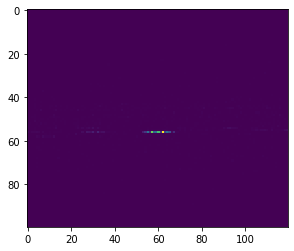

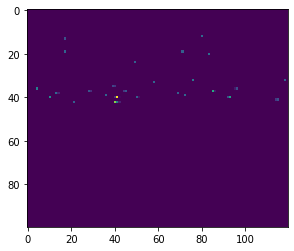

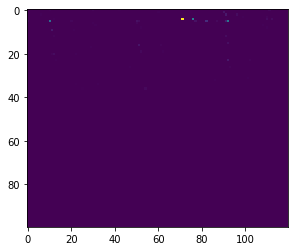

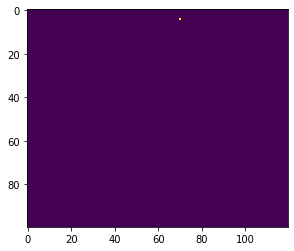

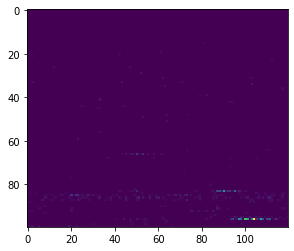

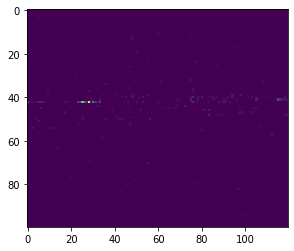

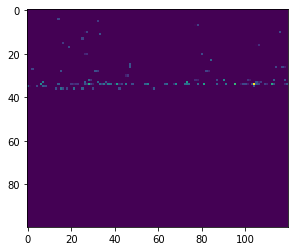

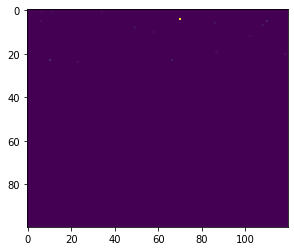

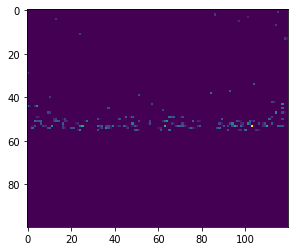

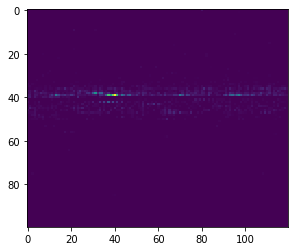

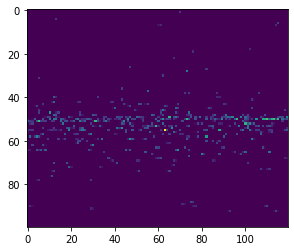

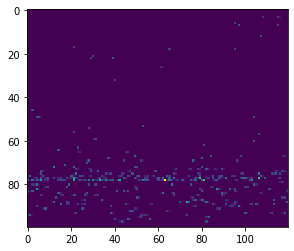

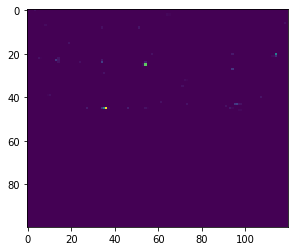

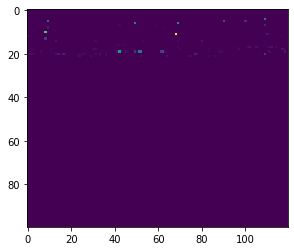

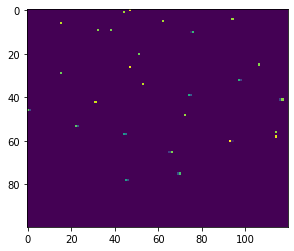

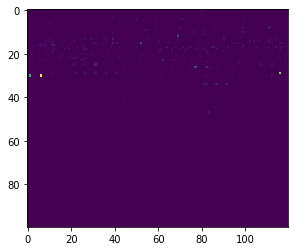

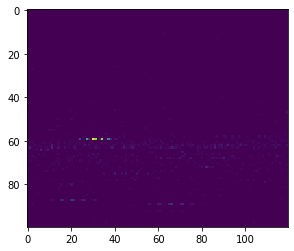

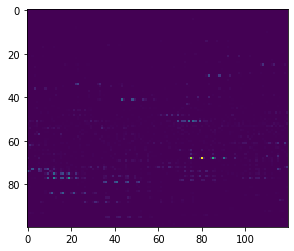

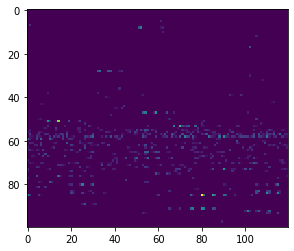

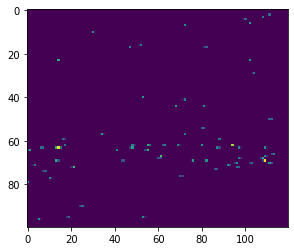

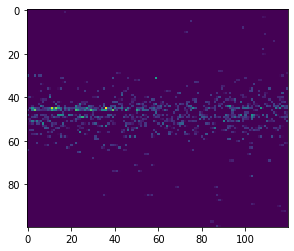

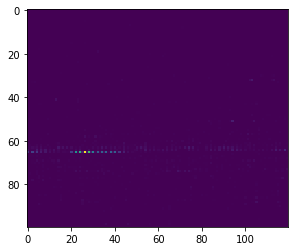

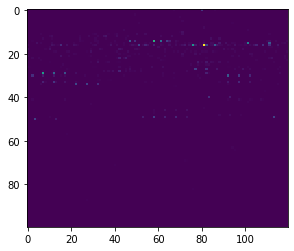

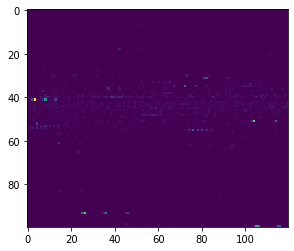

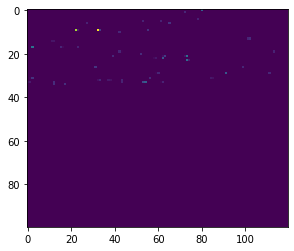

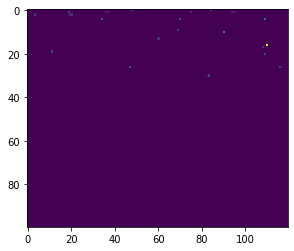

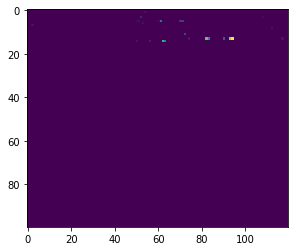

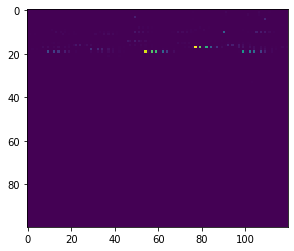

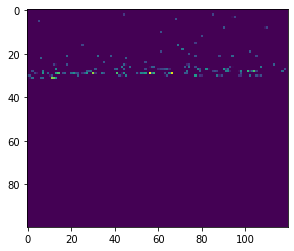

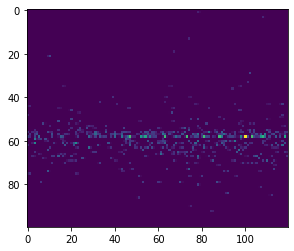

In [122]:
subplots(figsize=(10,12))
for i in range(100):
    plt.figure()
    plt.imshow(x_train[negative_index[3100+i],1:].reshape(100,120))

C:\Users\Richard\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


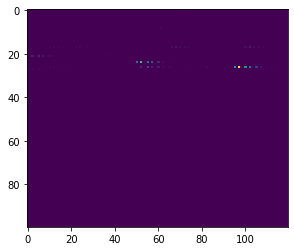

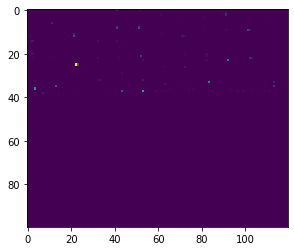

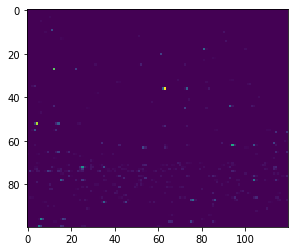

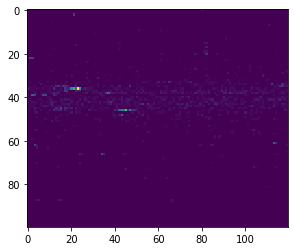

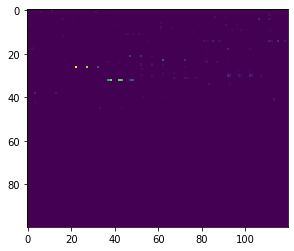

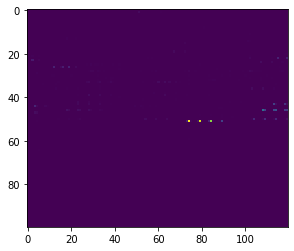

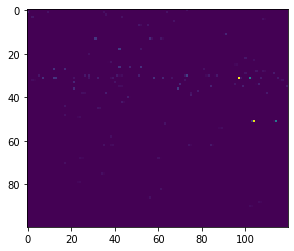

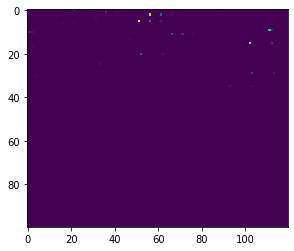

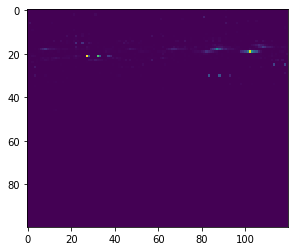

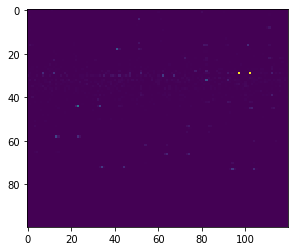

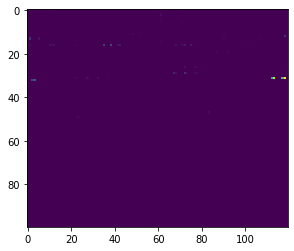

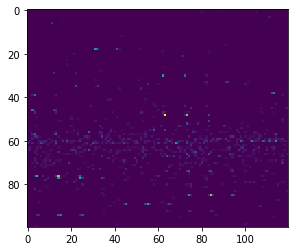

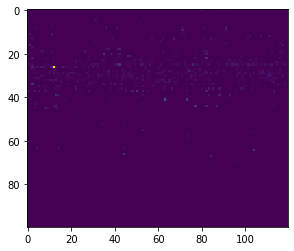

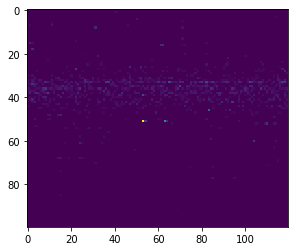

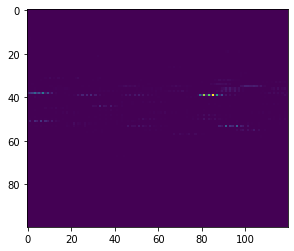

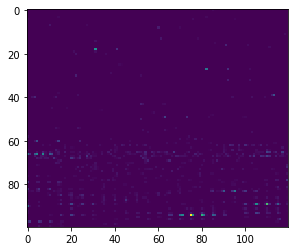

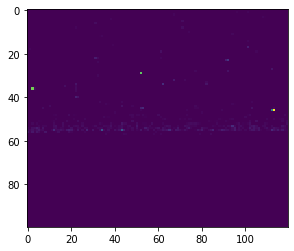

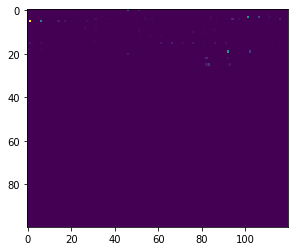

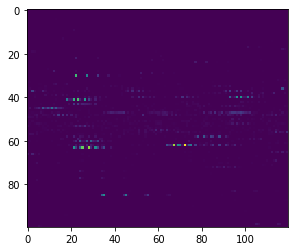

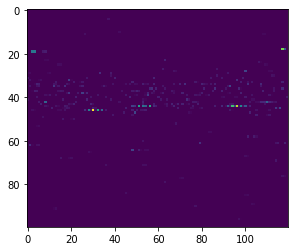

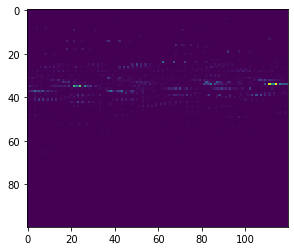

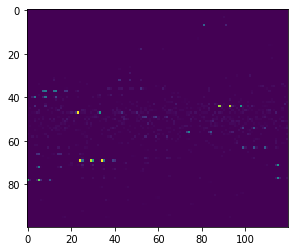

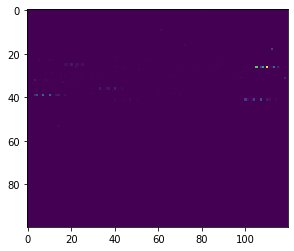

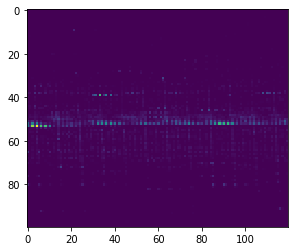

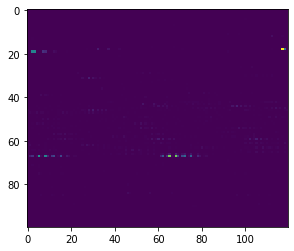

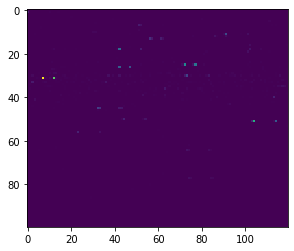

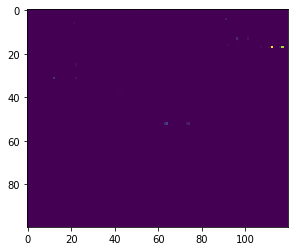

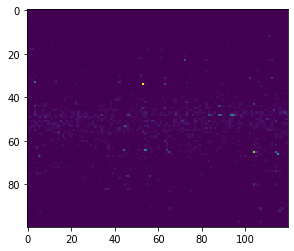

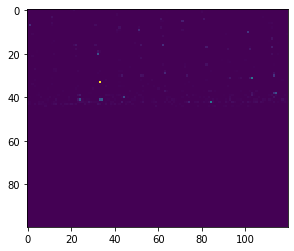

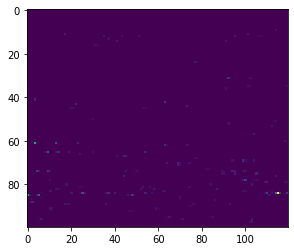

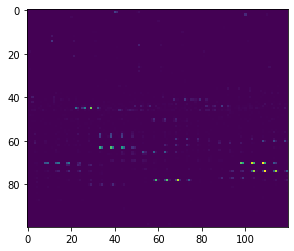

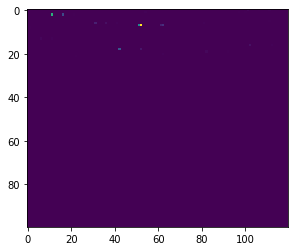

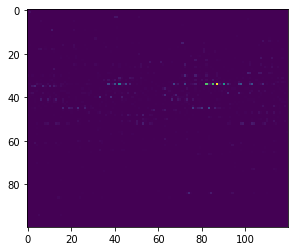

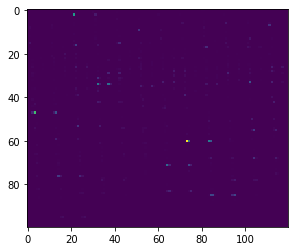

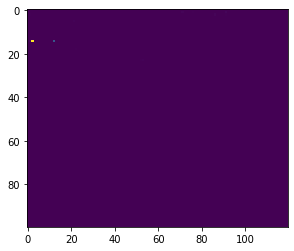

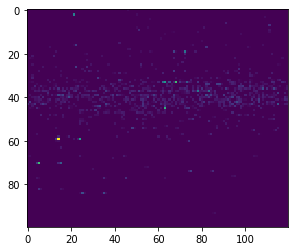

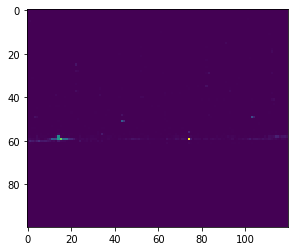

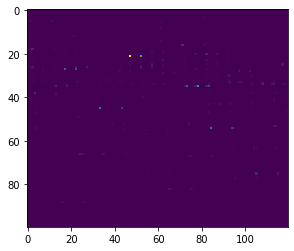

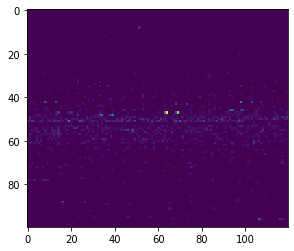

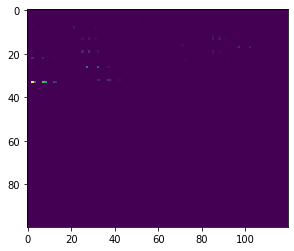

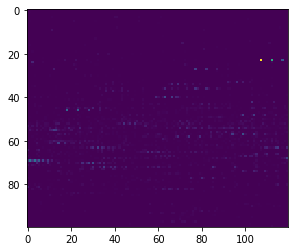

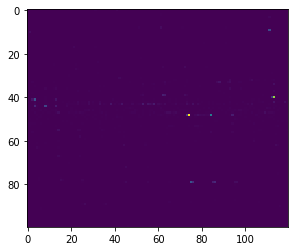

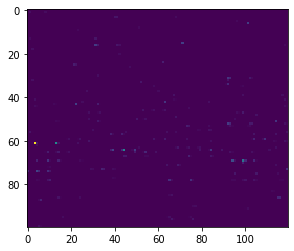

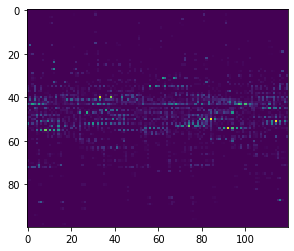

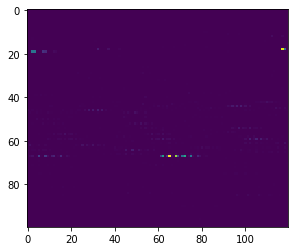

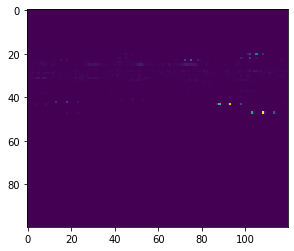

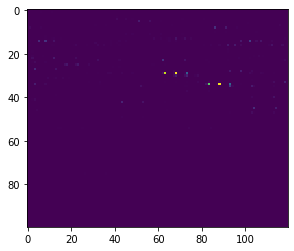

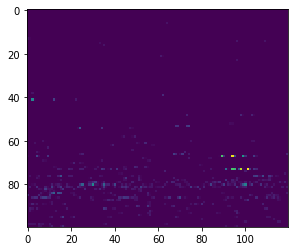

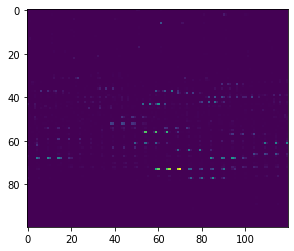

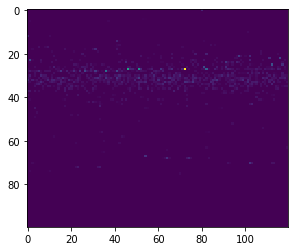

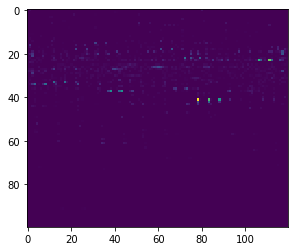

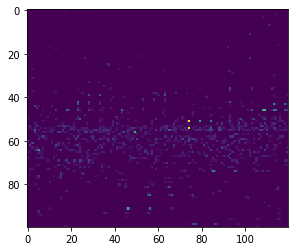

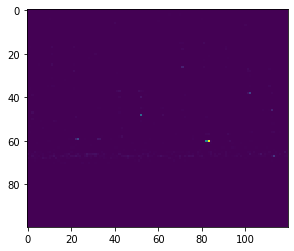

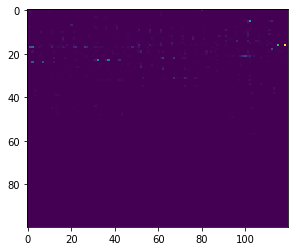

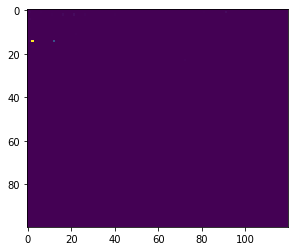

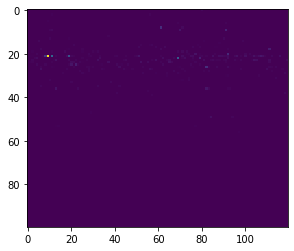

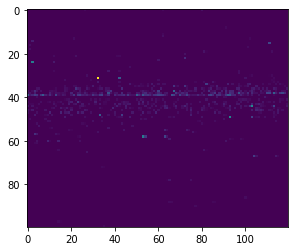

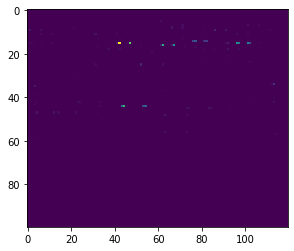

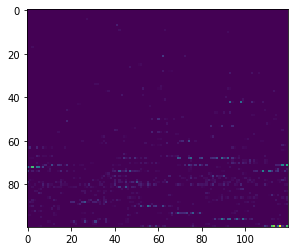

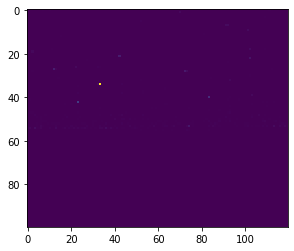

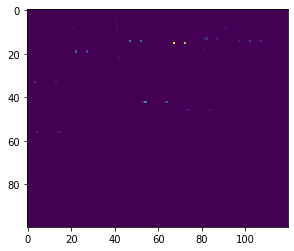

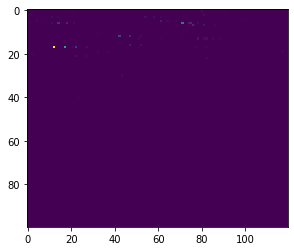

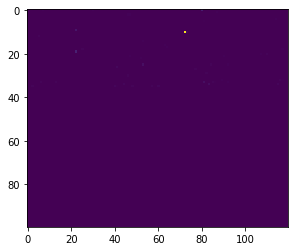

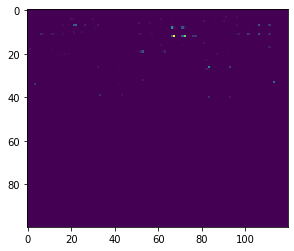

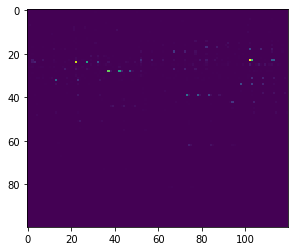

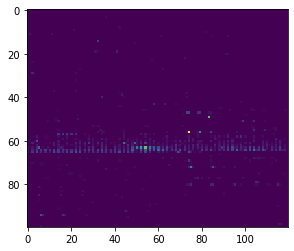

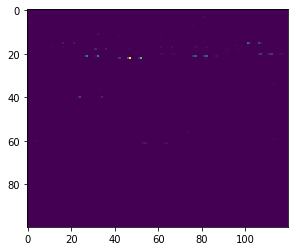

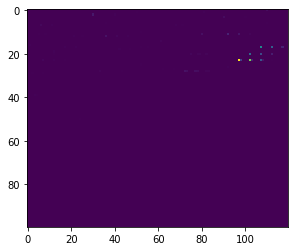

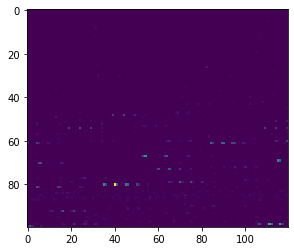

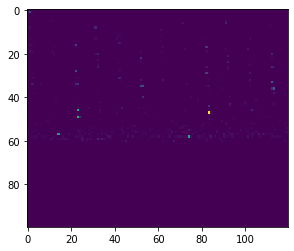

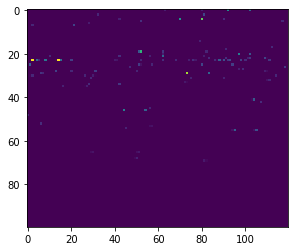

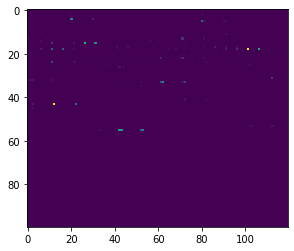

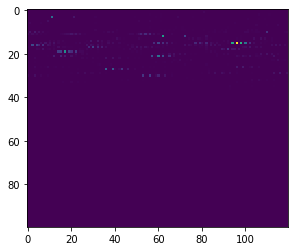

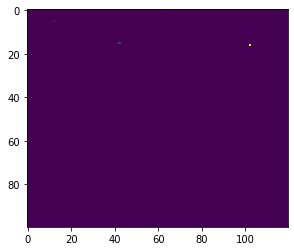

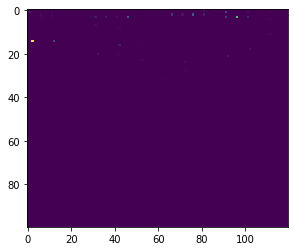

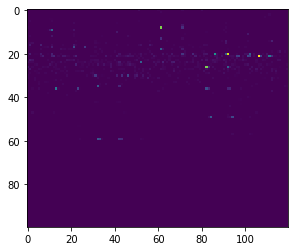

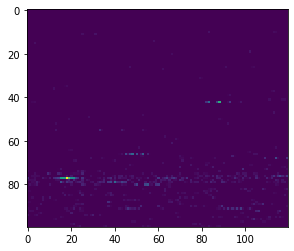

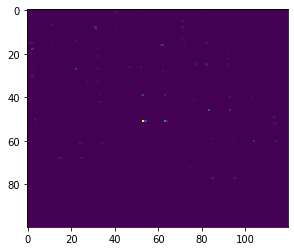

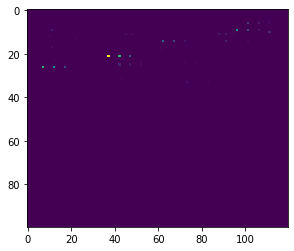

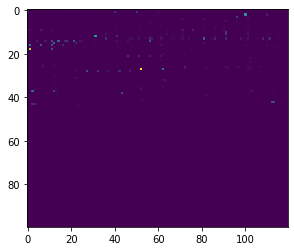

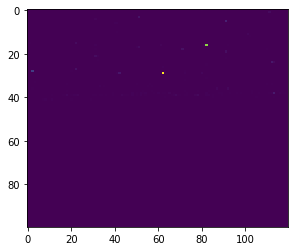

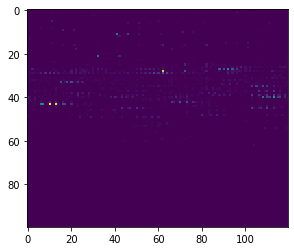

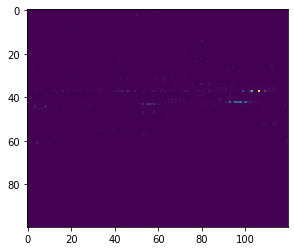

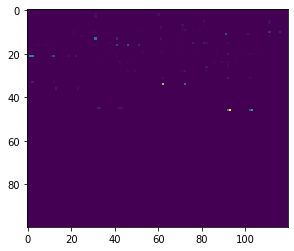

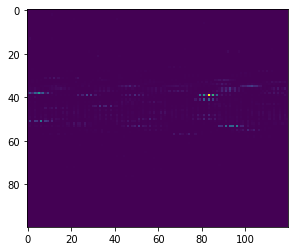

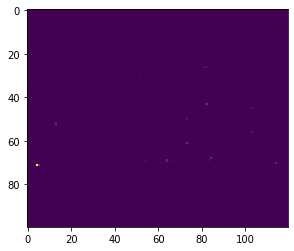

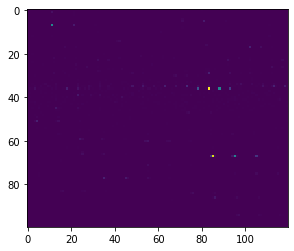

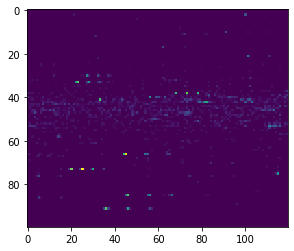

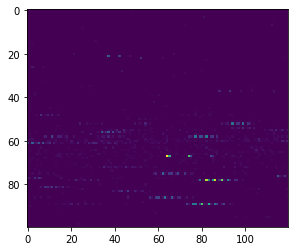

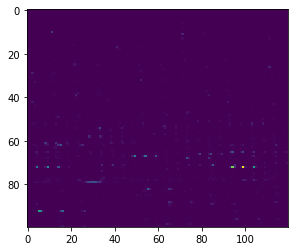

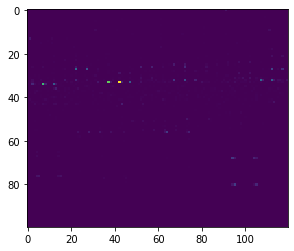

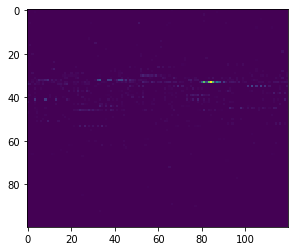

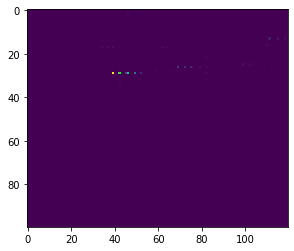

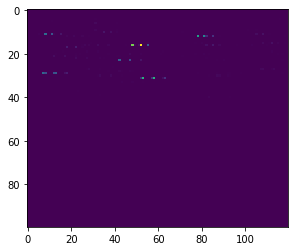

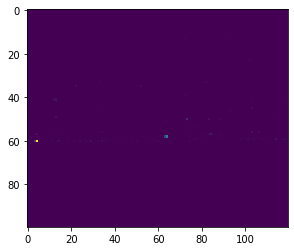

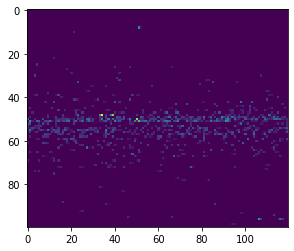

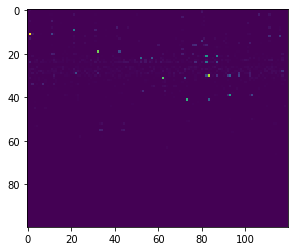

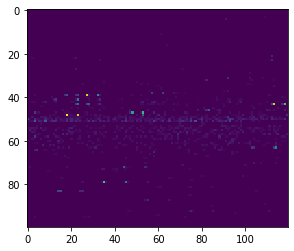

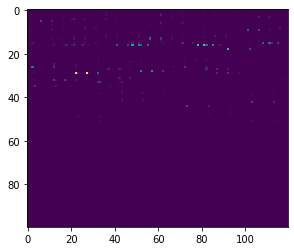

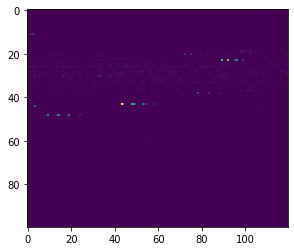

In [123]:
for i in range(100):
    plt.figure()
    plt.imshow(x_train[positive_index[1000+i],1:].reshape(100,120))